In [2]:
# Import general libraries
import json
import pandas as pd
import matplotlib.pyplot as plt

# Import local functions
from general_functions import *

In [2]:
# Import data
reghub_data_link = onedrive_download("https://1drv.ms/u/s!AoiE7xOoBAsngsgsIpu8x82sG1hvtw?e=mDKP33")
df = pd.read_csv(reghub_data_link)

categories_data_link = onedrive_download("https://1drv.ms/u/s!AoiE7xOoBAsngsgwWpNZyYMfloH33A?e=hTRtTD")
df_categories = pd.read_csv(categories_data_link)

In [4]:
# Import data
# Access aws credentials from json file
with open("../aws_credentials.json", 'r') as file:
    aws_creds_json = json.load(file)
# Specify s3 bucket
bucket = "fs-reghub-news-analysis"

# Connect to aws and dowload the files
aws = awsOps(aws_creds_json)
df = aws.get_df(bucket=bucket, file="data_rule_labels_updated_rough_cleaning.csv")
df_categories = aws.get_df(bucket=bucket, file="categories.csv")

In [6]:
df

,Unnamed: 0,_id,_index,_score,_type,concepts,found_dates,id,internal_links,keywords,...,news_title,news_topic,news_type,references,sentiment_label,sentiment_score,source_country,source_name,source_type,rule_labels_comb
0,0,fin1023Preslofreshbuy917302,2021_reghub_new,NaN,_doc,NaN,[],fin1023Preslofreshbuy917302,[],NaN,...,HelloFresh Buy von Joh. Berenberg Gossler & Co...,"[{""description"":""Berenberg Bank"",""relevance"":4...",Press releases,[],NaN,0.0,Global,finanzen.at,Information Provider,['market']
1,1,finichtenStoceaaufbuy322htm,2021_reghub_new,NaN,_doc,NaN,[],finichtenStoceaaufbuy322htm,[],NaN,...,BERENBERG stuft Nordea auf 'Buy' Finanznachri...,"[{""description"":""Berenberg Bank"",""relevance"":6...",Stock Analysis,[],NaN,0.0,Global,finanznachrichten.de,Information Provider,[]
2,2,fin1023Pressanofibuy917301,2021_reghub_new,NaN,_doc,NaN,[],fin1023Pressanofibuy917301,[],NaN,...,Sanofi Buy von Joh. Berenberg Gossler & Co. KG...,"[{""description"":""Berenberg Bank"",""relevance"":4...",Press releases,[],NaN,0.0,Global,finanzen.ch,Information Provider,[]
3,3,fin02023Presnbergbank917304,2021_reghub_new,NaN,_doc,NaN,[],fin02023Presnbergbank917304,[],NaN,...,Sartorius vz Buy (Joh. Berenberg Gossler & Co....,"[{""description"":""Berenberg Bank"",""relevance"":4...",Press releases,[],NaN,0.0,Global,finanzen.net,Information Provider,['guidelines']
4,4,walOnlineStocgstuftsanofibuy,2021_reghub_new,NaN,_doc,NaN,[],walOnlineStocgstuftsanofibuy,[],NaN,...,BERENBERG stuft SANOFI auf 'Buy' 30.10.2023 ...,"[{""description"":""Berenberg Bank"",""relevance"":6...",Stock Analysis,[],NaN,0.0,Global,wallstreet-online.de,Information Provider,['guidelines']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496,14603,EurchosPres9fa0e44b60enhtml,2021_reghub_new,NaN,_doc,NaN,[],EurchosPres9fa0e44b60enhtml,[],NaN,...,Andrea Enria: Interview with Les Échos,"[{""description"":""Compliance"",""relevance"":7,""co...",Press releases,[],NaN,0.0,European Union (EU),European Central Bank (ECB),Central bank,"['legal', 'statements', 'guidelines']"
14497,14604,UBSWillPresllhtmlcaasIDRSS,2021_reghub_new,NaN,_doc,NaN,[],UBSWillPresllhtmlcaasIDRSS,[],NaN,...,Das FintechPortfolio von UBS investiert in die...,"[{""description"":""Digital Transformation"",""rele...",Press releases,[],NaN,0.0,Global,UBS Media Releases,Financial Service Provider,['reports']
14498,14605,invrankenPresnd26mrdfranken,2021_reghub_new,NaN,_doc,NaN,[],invrankenPresnd26mrdfranken,[],NaN,...,SNB erwartet für 2021 Jahresgewinn von rund 26...,"[{""description"":""Controlling"",""relevance"":33,""...",Press releases,[],NaN,0.0,Switzerland,investrends,Information provider,"['legal', 'reports', 'guidelines']"
14499,14606,CoirawalsPrestomerswithdrawals,2021_reghub_new,NaN,_doc,NaN,[],CoirawalsPrestomerswithdrawals,[],NaN,...,Hong Kongbased Coinsuper allegedly blocks cust...,"[{""description"":""Daytrading"",""relevance"":49,""c...",Social Media,[],NaN,0.0,Global,Cointelegraph,Information provider,"['sanctions', 'reports', 'statements', 'guidel..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14608 entries, 0 to 14607
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                14578 non-null  object 
 1   _index             14552 non-null  object 
 2   _score             29 non-null     object 
 3   _type              14526 non-null  object 
 4   concepts           2260 non-null   object 
 5   found_dates        13808 non-null  object 
 6   id                 14532 non-null  object 
 7   internal_links     13759 non-null  object 
 8   keywords           2369 non-null   object 
 9   language           14516 non-null  object 
 10  news_author        1990 non-null   object 
 11  news_content       14501 non-null  object 
 12  news_date          14504 non-null  object 
 13  news_label         238 non-null    object 
 14  news_last_updated  11 non-null     object 
 15  news_legalinforce  14504 non-null  object 
 16  news_link          145

In [5]:
# Add spaces before and after the strings to avoid 
# partially matching wrong words with short keys
df_categories = df_categories.map(lambda x: f' {x} ')

In [6]:
df_categories.to_csv("../../testing_spaces.csv")

In [7]:
# Clean the df
df.dropna(subset=["news_content"], inplace=True)
# Create a list of the newly created columns for later use
rule_cols = []
# Create rule based category labels
for category in df_categories.columns[1:]:
    # Keep track of which keywords led to categorization
    df_categories[f"{category}_count"] = 0
    # Add columns for rule-based labels
    df[f"rule_labels_{category}"] = "Other"
    rule_cols.append(f"rule_labels_{category}")
    # Match words from the category lists
    for index, row in df.iterrows():
        for word in list(df_categories[category].dropna()):
            if word.lower() in str(row["news_content"]).lower():
                df.at[index, f"rule_labels_{category}"] = category
                df_categories.loc[df_categories[category] == word, f"{category}_count"] += 1

In [8]:
# Compress the four category columns into one
df['rule_labels_comb'] = df[rule_cols].values.tolist()
df['rule_labels_comb'] = df['rule_labels_comb'].apply(lambda lst: [val for val in lst if val != 'Other'])
df.drop(columns=rule_cols, inplace=True)

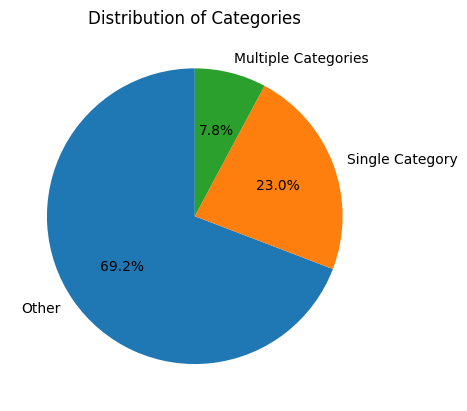

In [9]:
# Visulaization
count_empty = df['rule_labels_comb'].apply(len).eq(0).sum()
count_single = df['rule_labels_comb'].apply(len).eq(1).sum()
count_multiple = df['rule_labels_comb'].apply(len).gt(1).sum()

# Data for plotting
labels = ['Other', 'Single Category', 'Multiple Categories']
sizes = [count_empty, count_single, count_multiple]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create a pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Categories')
plt.show()

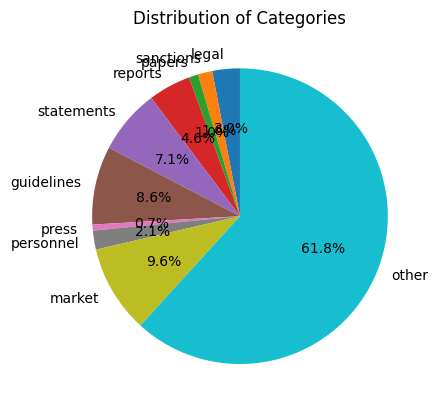

In [10]:
# Visualization
vis_cats = []
for category in df_categories.columns[1:10]:
    vis_cats.append(df['rule_labels_comb'].apply(lambda lst: lst.count(category)).sum())
vis_cats.append(df['rule_labels_comb'].apply(len).eq(0).sum())

# Data for plotting
labels = list(df_categories.columns[1:10]) + ["other"]
sizes = vis_cats
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create a pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Categories')
plt.show()

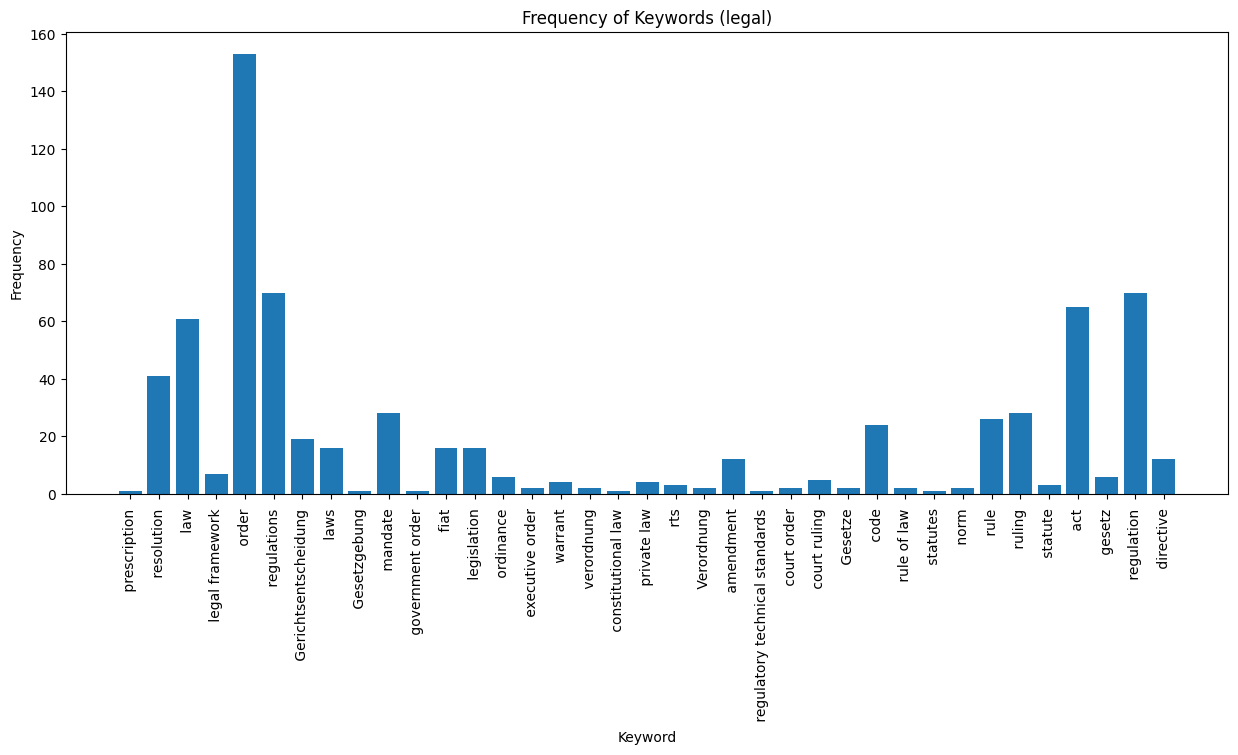

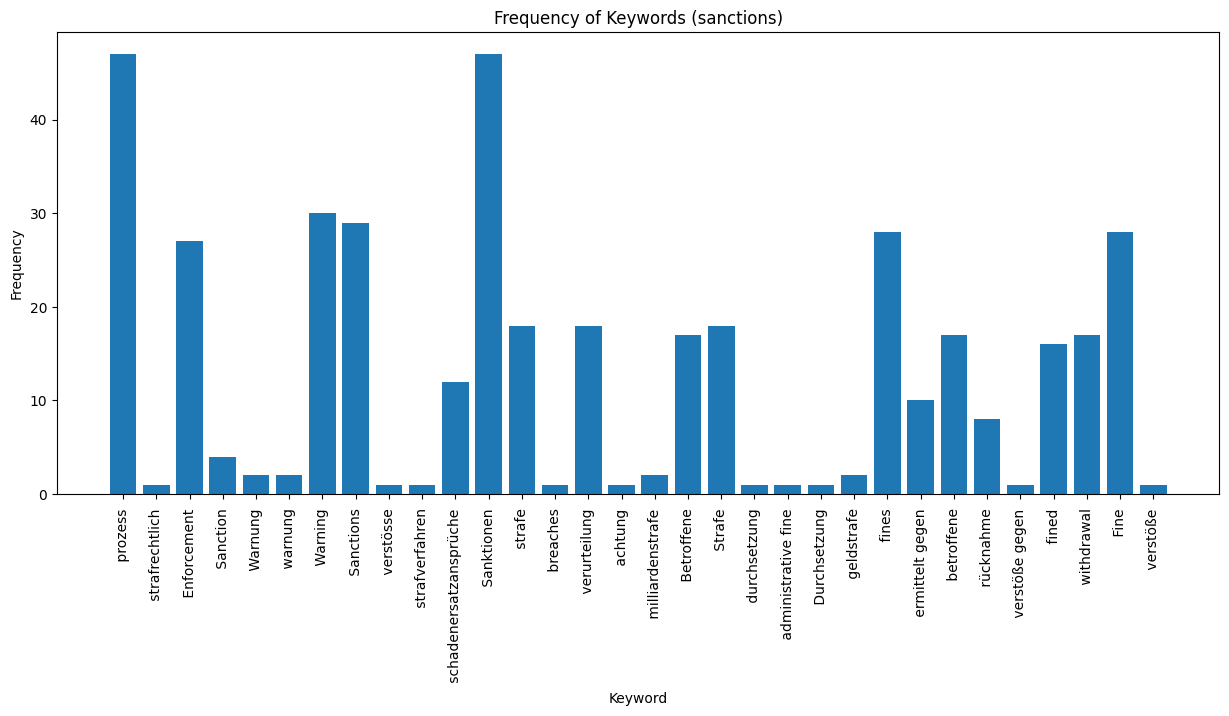

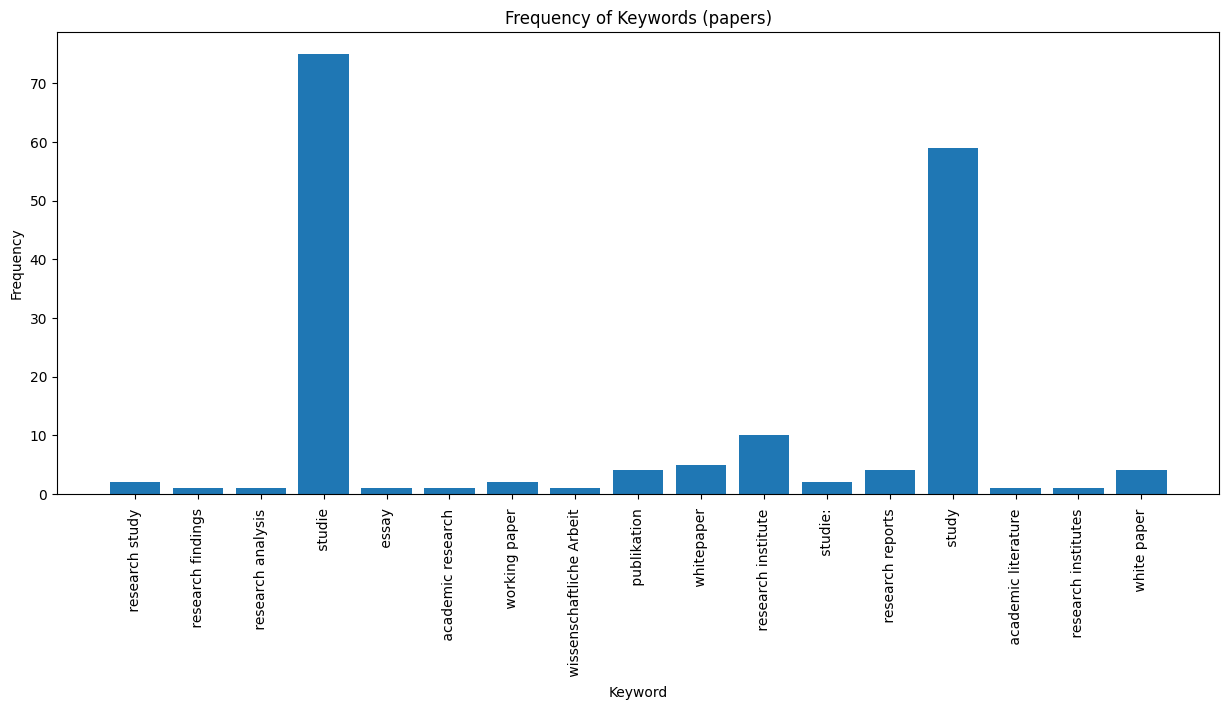

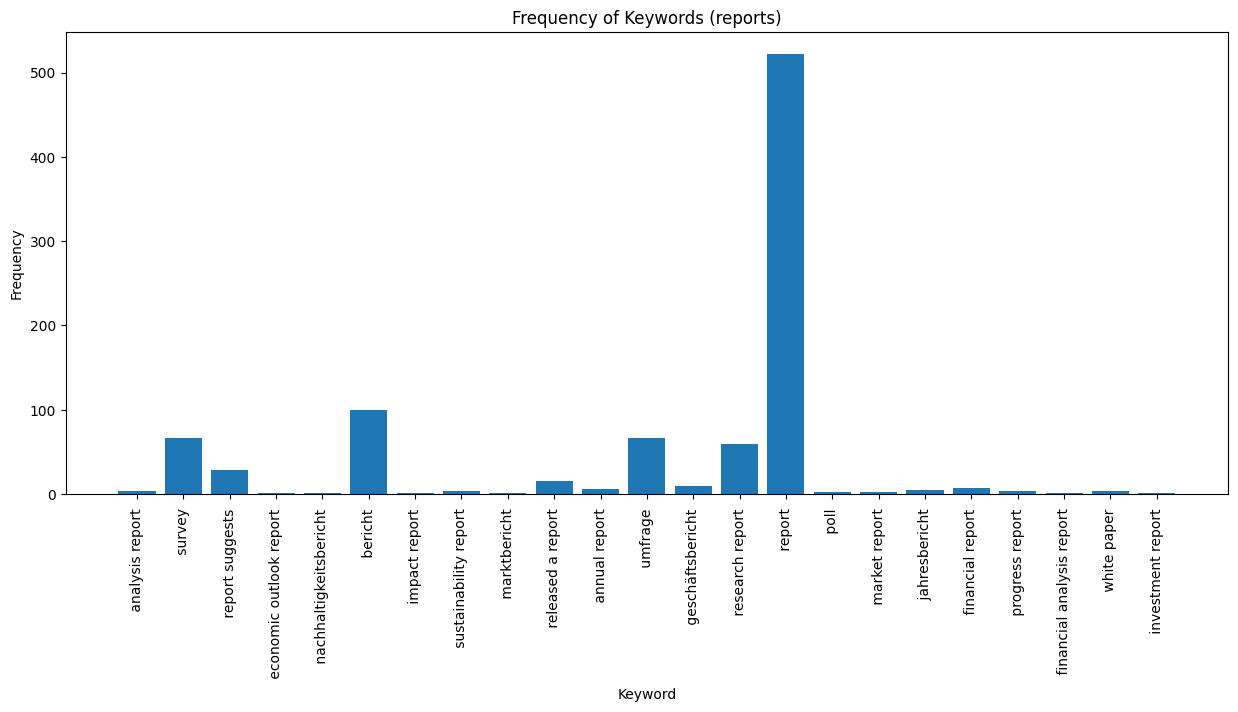

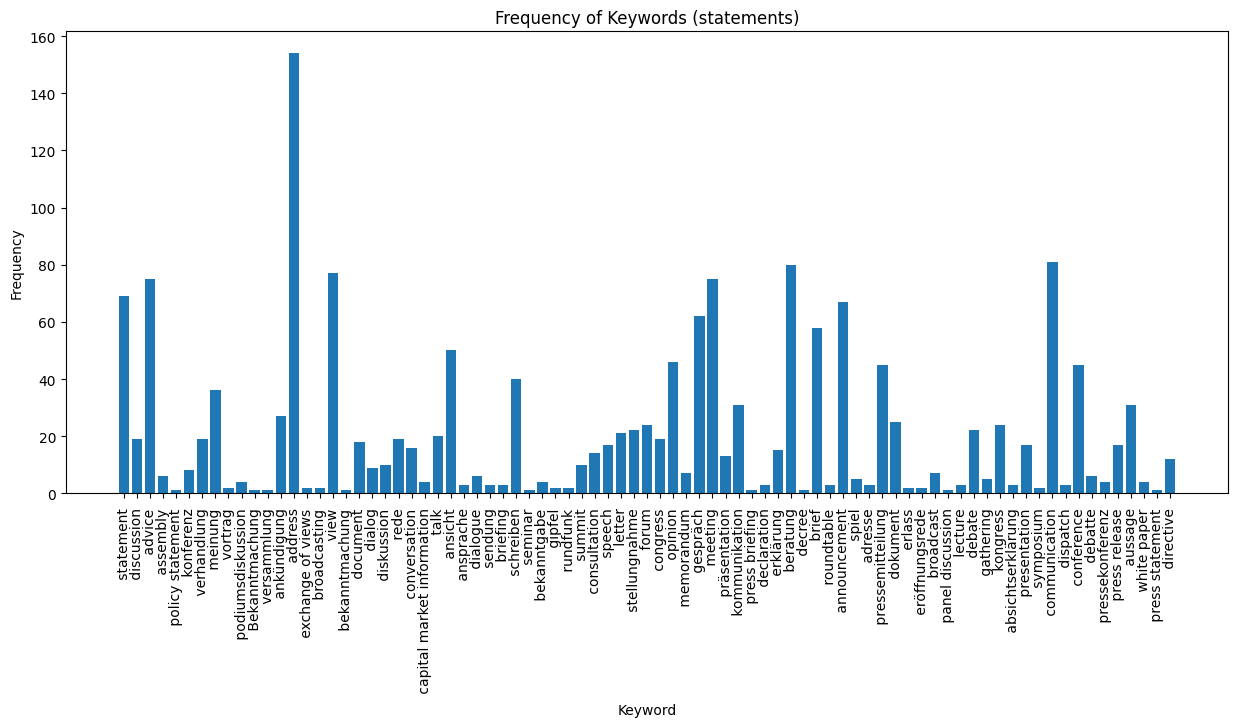

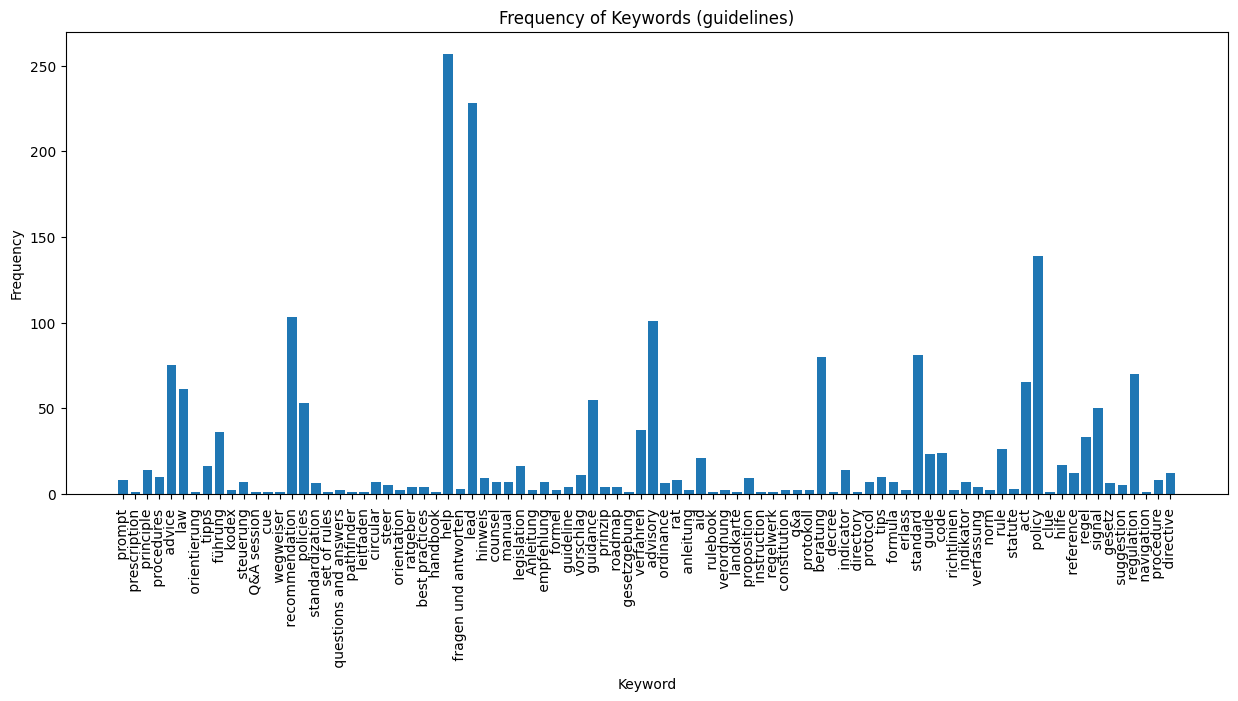

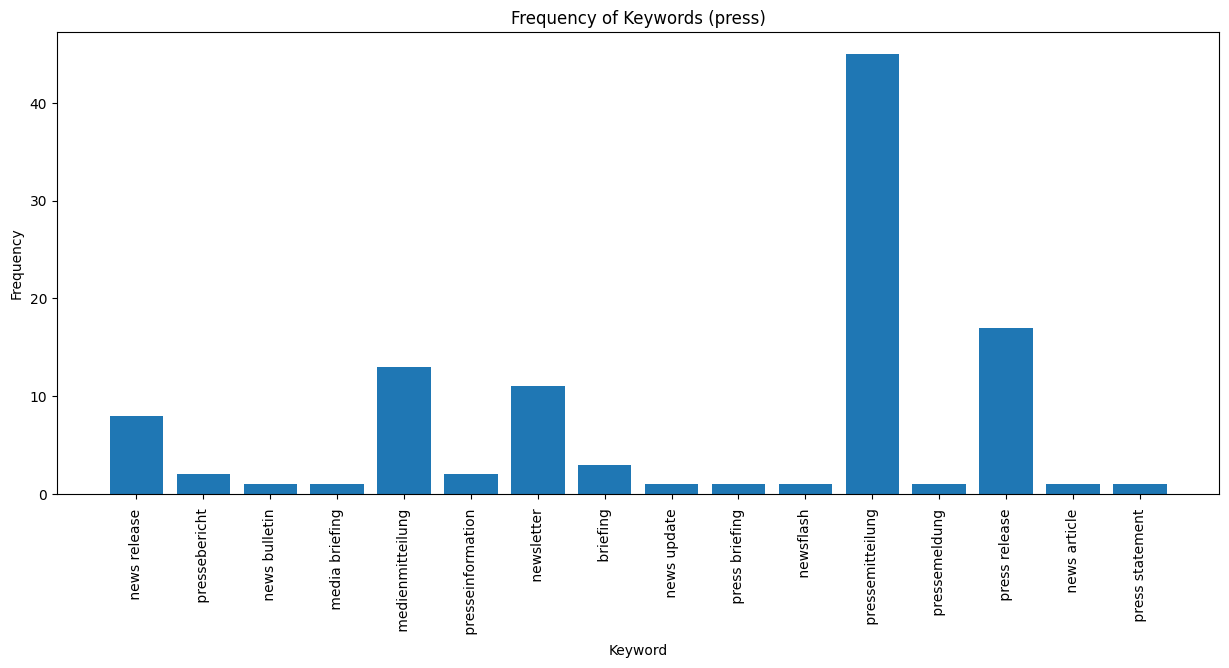

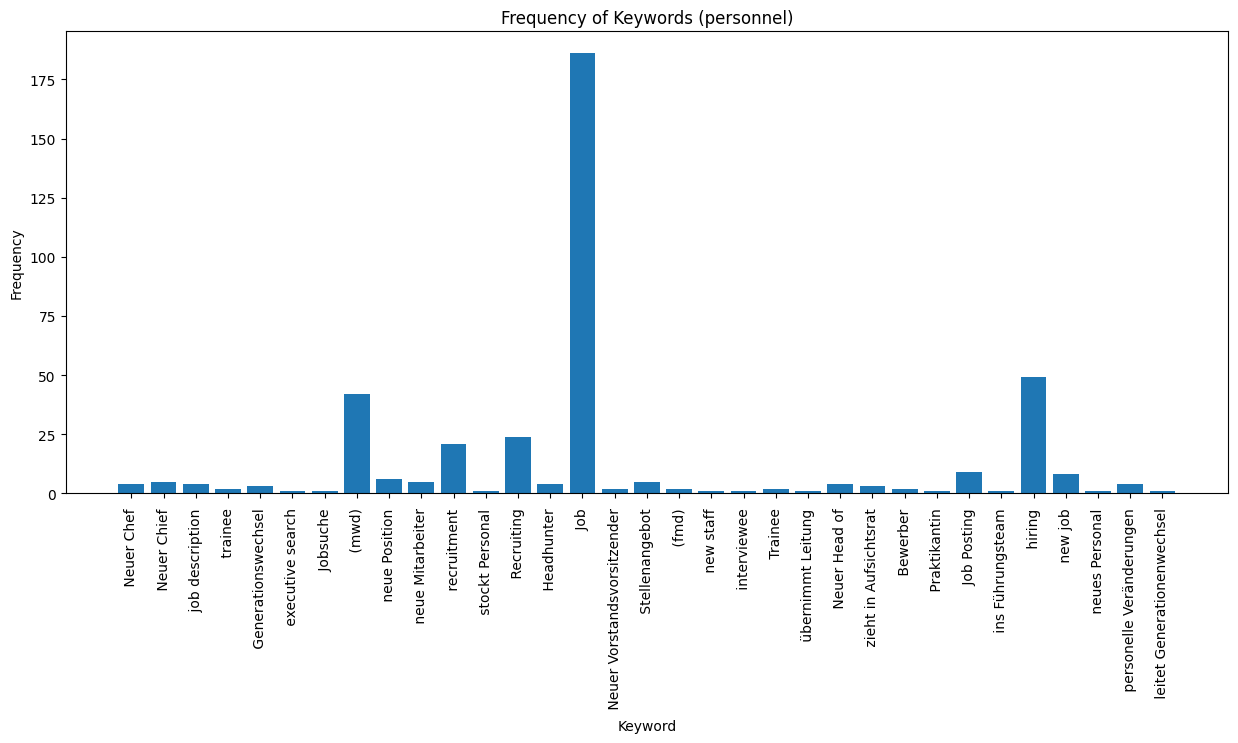

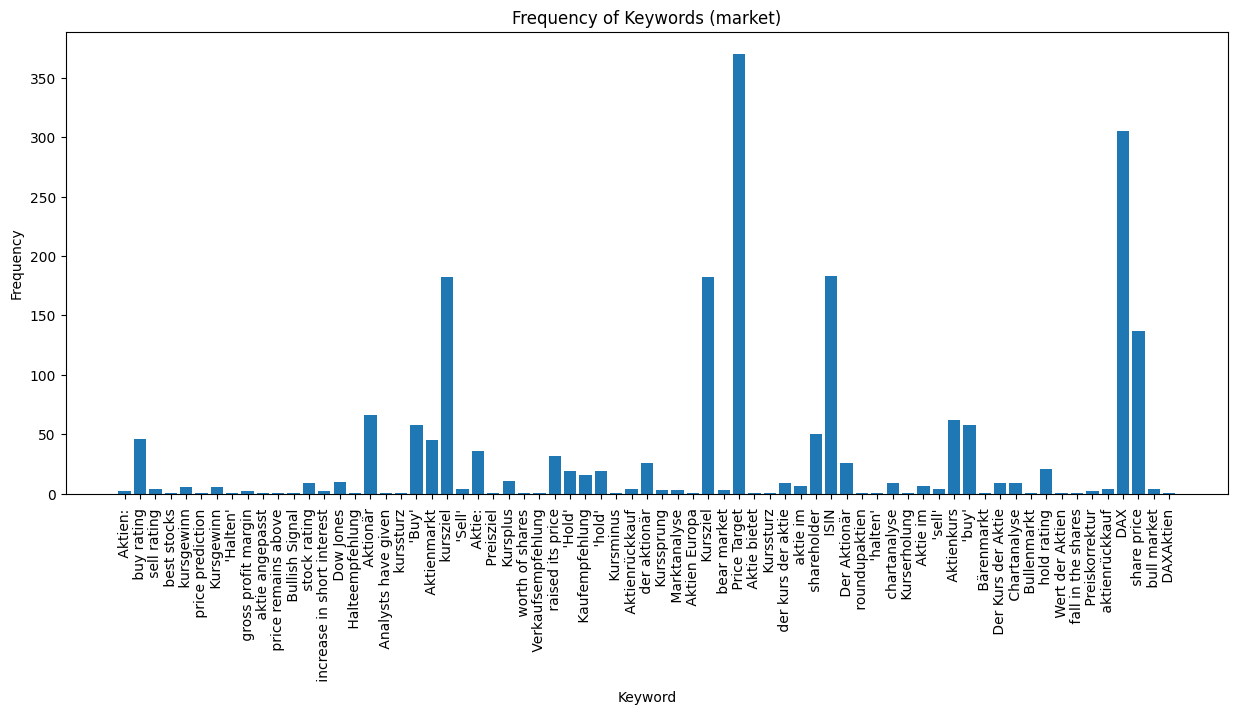

In [11]:
# Iterate over the columns
for column in df_categories.columns[1:10]:
    # Filter the dataframe for non-zero values in the current column
    df_nonzero = df_categories[df_categories[f"{column}_count"] != 0]

    # Calculate the frequency of each category
    keyword_counts = df_nonzero[f"{column}_count"]
    category_names = df_nonzero[column].unique()

    # Create a bar chart
    plt.figure(figsize=(15, 6))
    plt.bar(category_names, keyword_counts)
    plt.title(f'Frequency of Keywords ({column})')
    plt.xlabel('Keyword')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

In [12]:
df.to_csv("../../data_rule_labels_updated.csv")